In [19]:
import os
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle

from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
import pyecharts
from pyecharts import options as opts
from pyecharts.charts import Liquid
from pyecharts.globals import SymbolType

In [20]:
location = os.getenv("location")
df = pd.read_csv(f'./dataset/edge-{location}.csv', sep=',', lineterminator='\n')
print(df.head())

             user  user_followers retweeted_user  \
0           tuzzi            5517  JohnDennisFCO   
1     InCytometry             927  AlastairMcA30   
2      RouachEric             514  Europe_Israel   
3  GartsideJackie             694    charlesbrew   
4         SAFF1YA            1543   xunnysideup_   

                                                text  \
0  today k doses covax astra zeneca vaccine arriv...   
1  persist spreading misinformation vaccines ampl...   
2  apaheid un arabe israélien confirme qu ’ israë...   
3  studies vaccine vs natural immunity covid yes ...   
4  gurl israel yg buat vaccine tu ’ think governm...   

   retweeted_user_followers sentiment  polarity  subjectivity    neg    neu  \
0                       767   neutral      0.00        0.0000  0.000  1.000   
1                     28118  negative      0.00        0.0000  0.277  0.723   
2                     15822   neutral      0.00        0.0000  0.000  1.000   
3                      2037  posit

In [21]:
G_retweet = nx.from_pandas_edgelist(df,
                                    source = "user",
                                    target = "retweeted_user",
                                    create_using = nx.DiGraph())

In [22]:
print('There are {} Nodes inside Retweet Network'.format(len(G_retweet.nodes())))

There are 305 Nodes inside Retweet Network


In [23]:
print('There are {} Edges inside Retweet Network'.format(len(G_retweet.edges())))

There are 158 Edges inside Retweet Network


In [24]:
print(nx.density(G_retweet))

0.0017040552200172563


In [25]:
info=nx.info(G_retweet)
print(info)

Name: 
Type: DiGraph
Number of nodes: 305
Number of edges: 158
Average in degree:   0.5180
Average out degree:   0.5180


In [26]:
degree_sequence = sorted([d for n, d in G_retweet.degree()], reverse=True)
dmax = max(degree_sequence)
print(f'Maximum degree is {dmax}')

Maximum degree is 6


In [27]:
degree_sequence = sorted([d for n, d in G_retweet.in_degree()], reverse=True)
dmax_in = max(degree_sequence)
print(f'Maximum in degree is {dmax_in}')

Maximum in degree is 4


In [28]:
degree_sequence = sorted([d for n, d in G_retweet.out_degree()], reverse=True)
dmax_out = max(degree_sequence)
print(f'Maximum out degree is {dmax_out}')

Maximum out degree is 2


In [29]:
print(f'Assortativity is {nx.degree_assortativity_coefficient(G_retweet)}')

Assortativity is -0.05232248642363502


In [30]:
sentiment = pd.Series(list(df['sentiment']), index=df.retweeted_user).to_dict()
nx.set_node_attributes(G_retweet, sentiment, 'sentiment')
sentiment = pd.Series(list(df['sentiment']), index=df.user).to_dict()
nx.set_node_attributes(G_retweet, sentiment, 'sentiment')

In [31]:
no_followers = pd.Series(list(df['retweeted_user_followers']), index=df.retweeted_user).to_dict()
nx.set_node_attributes(G_retweet, no_followers, 'followers')
no_followers = pd.Series(list(df['user_followers']), index=df.user).to_dict()
nx.set_node_attributes(G_retweet, no_followers, 'followers')

In [32]:
colors = []
for n in G_retweet.nodes(data = True):
    if n[1]['sentiment'] == 'positive':
        colors.append('lightskyblue')
    elif n[1]['sentiment'] == 'negative':
        colors.append('lightcoral')
    else:
        colors.append('limegreen')

In [33]:
sizes = [n[1]['followers'] /2000 for n in G_retweet.nodes(data = True)]

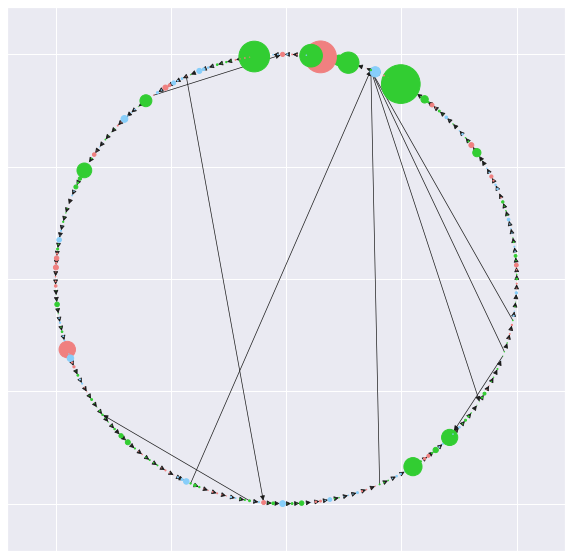

In [34]:
plt.figure(figsize=(10,10)) 
nx.draw_networkx(G_retweet,
                     pos = nx.circular_layout(G_retweet),
                     with_labels = False,
                     node_size = sizes,
                     width = 0.7,
                     arrows = True,
                     arrowsize=10,
                     node_color = colors)
plt.savefig(f'./results/digraph_{location}')

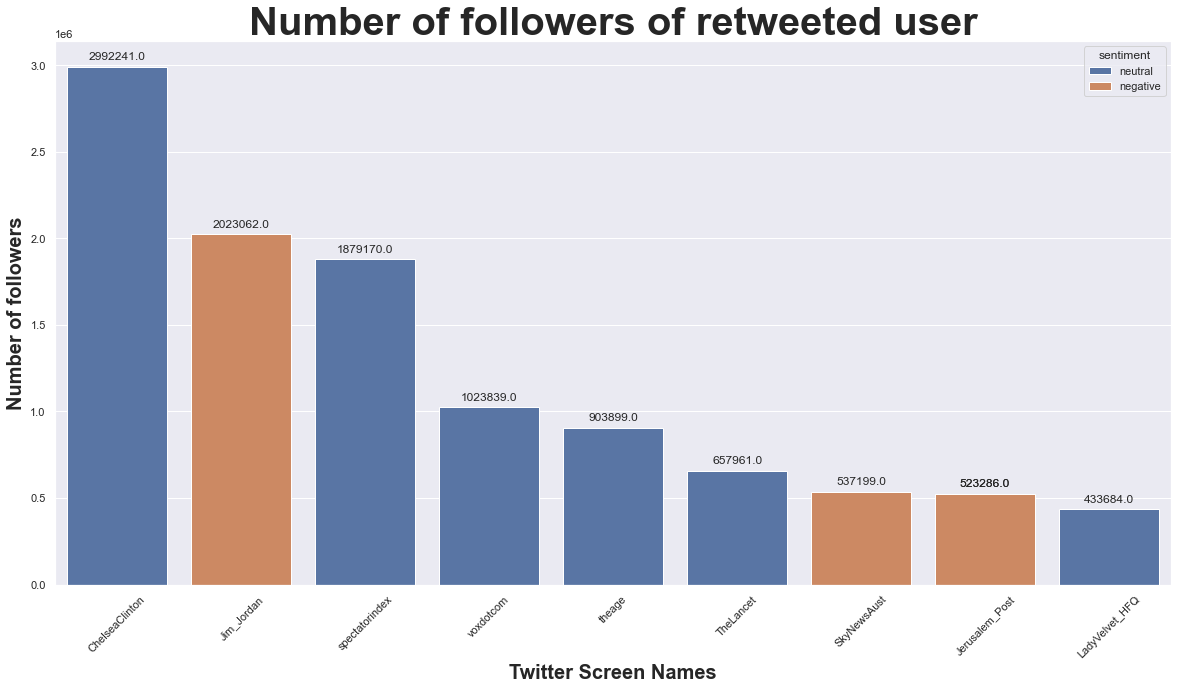

<Figure size 432x288 with 0 Axes>

In [35]:
plt.figure(figsize=(20,10)) #customizing the size of the plot
sns.set(style="darkgrid") #customizing the style of the plot
#visualizing the data using bar plot
ax = sns.barplot(x='retweeted_user', y='retweeted_user_followers', hue="sentiment", dodge=False,
                data=df.sort_values(by='retweeted_user_followers', ascending=False)[0:10]
                )
#getting the values of the data
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2.,
                            p.get_height()), ha = 'center', va = 'center', 
                            xytext = (0, 10), textcoords = 'offset points')
#setting the parameters for the title, x and y labels of the plot
ax.set_title("Number of followers of retweeted user", size=40, weight='bold')
ax.set_xlabel("Twitter Screen Names", size=20, weight='bold')
ax.set_ylabel("Number of followers", size=20, weight='bold')
#changing the rotation of the x axis tick labels 
for item in ax.get_xticklabels():
    item.set_rotation(45)
    
plt.show()
plt.savefig(f'./results/no_followers_{location}')

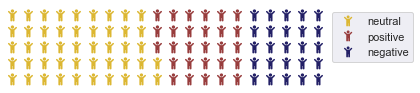

<Figure size 432x288 with 0 Axes>

In [36]:
data = dict(df['sentiment'].value_counts().map(lambda x: (x / len(df))*100))
fig = plt.figure(
    FigureClass=Waffle,
    rows=5, 
    values=data, 
    colors=["#DCB732", "#983D3D", "#232066"],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', 
    font_size=12,
    icon_legend=True
)

plt.show()
plt.savefig(f'./results/sentiment_logo_{location}')

In [37]:
israel_data = [0.60, 0.56]
hk_data = [0.16, 0.11]

def liquid_graph(data):
    c = (
        Liquid()
        .add("vaccinated", data)
        .set_global_opts(title_opts=opts.TitleOpts(title="Liquid-graph"))
    )
    return c

In [38]:
if location == "israel": liquid_graph(israel_data).render_notebook()
else: liquid_graph(hk_data).render_notebook()

In [39]:
if location == "israel": liquid_graph(israel_data).render(f'./results/liquid_{location}.html')
else: liquid_graph(hk_data).render(f'./results/liquid_{location}.html')